In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

### Q1 

In [2]:
data = pd.read_csv('bank.csv', sep=';')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [5]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
data['y'].unique()

array(['no', 'yes'], dtype=object)

In [7]:
# Step 3: Convert 'yes'/'no' to binary (1/0)
data['y'] = data['y'].replace({'yes': 1, 'no': 0})

# Alternatively, you can use map
# df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Verify the conversion
print(data['y'].unique())

[0 1]


In [8]:
columns_to_keep = [
    'age', 'job', 'marital', 'education', 'balance',
    'housing', 'contact', 'day', 'month', 
    'duration', 'campaign', 'pdays', 'previous', 
    'poutcome', 'y'
]
df_filtered = data[columns_to_keep]

In [9]:
df_train_full, df_test = train_test_split(df_filtered, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["y"]
y_val = df_val["y"]
y_test = df_test["y"]

del df_train["y"]
del df_val["y"]
del df_test["y"]

In [10]:
numerical_variables = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

auc_scores = {}

for var in numerical_variables:

    auc_score = roc_auc_score(y_train, df_train[var])
    
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[var])
        auc_scores[var] = (auc_score, True)  # True indicates inversion
    else:
        auc_scores[var] = (auc_score, False)  # False indicates no inversion

highest_auc_variable = max(auc_scores.items(), key=lambda x: x[1][0])

print(f"The variable with the highest AUC is '{highest_auc_variable[0]}' with an AUC of {highest_auc_variable[1][0]:.4f}.")
if highest_auc_variable[1][1]:
    print("This variable was inverted.")

The variable with the highest AUC is 'duration' with an AUC of 0.8109.


### Q2

In [11]:
train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False) # don't use sparse matrix
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
y_preds = model.predict(X_val)
score = roc_auc_score(y_val, y_preds)
print(score)

0.6694956093381881


### Q3

/home/malloy/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


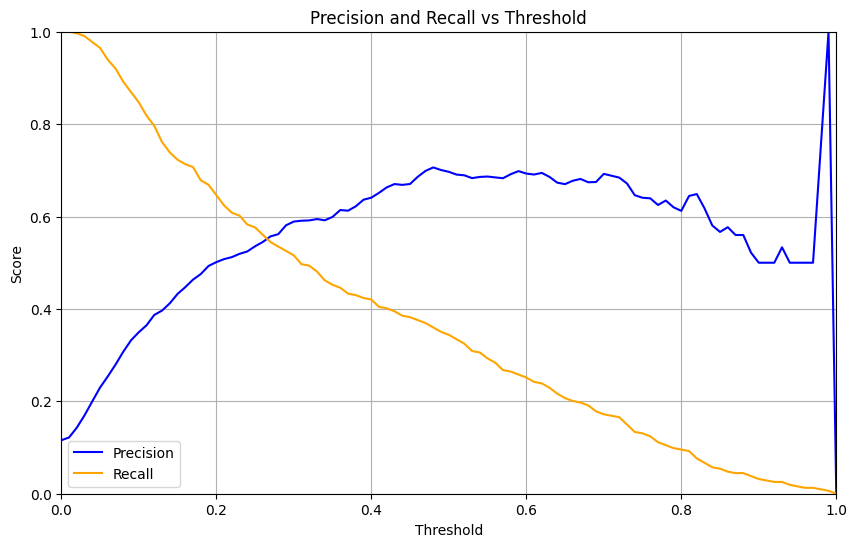

In [13]:
y_probs = model.predict_proba(X_train)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### Q4

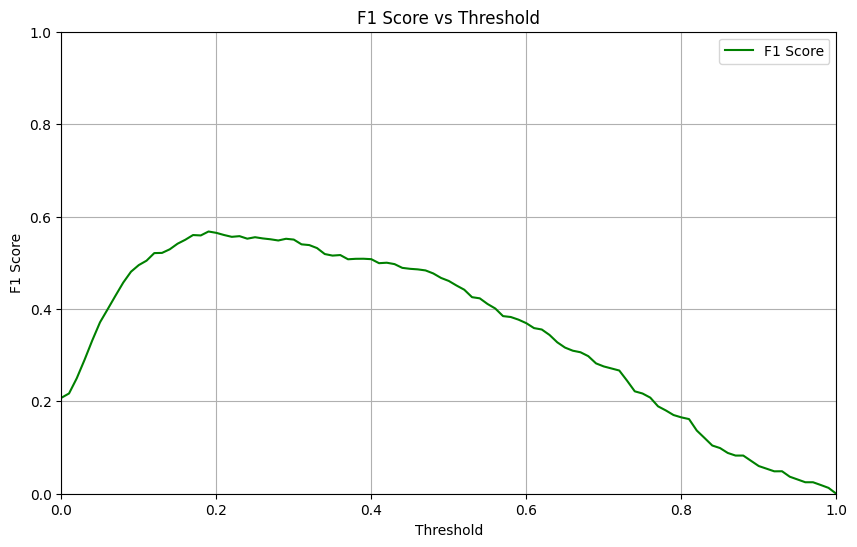

In [14]:
f1_scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    
    f1 = f1_score(y_train, y_pred)
    
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### Q5

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(X_train):
    train_x, val_x = X_train[train_index], X_train[val_index]
    train_y, val_y = y_train[train_index], y_train[val_index]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, y_val_probs)
    auc_scores.append(auc_score)

average_auc = np.mean(auc_scores)
print(average_auc)
print(np.round(np.std(auc_scores), 3))

0.9123741700578283
0.0


In [16]:
auc_scores

[0.9123741700578283,
 0.9123741700578283,
 0.9123741700578283,
 0.9123741700578283,
 0.9123741700578283]

### Q6

In [17]:
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    auc_scores = []
    
    for train_index, val_index in kf.split(X_train):
        train_x, val_x = X_train[train_index], X_train[val_index]
        train_y, val_y = y_train[train_index], y_train[val_index]
       
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(train_x, train_y)
        
        y_val_probs = model.predict_proba(val_x)[:, 1]

        auc_score = roc_auc_score(val_y, y_val_probs)
        auc_scores.append(auc_score)

    mean_auc = np.round(np.mean(auc_scores), 3)
    std_auc = np.round(np.std(auc_scores), 3)

    results[C] = (mean_auc, std_auc)

for C, (mean_auc, std_auc) in results.items():
    print(f'C: {C}, Mean AUC: {mean_auc}, Std AUC: {std_auc}')

C: 1e-06, Mean AUC: 0.288, Std AUC: 0.031
C: 0.001, Mean AUC: 0.759, Std AUC: 0.033
C: 1, Mean AUC: 0.883, Std AUC: 0.007
